In [6]:
import numpy as np
import cv2
import skimage.util as skp
from  skimage.metrics import peak_signal_noise_ratio, structural_similarity
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [92]:
class ExperimentHelper:
    def __init__(self, img, title):
        self.image = img
        self.original_image = img
        self.title = title
        self.psnr = float('inf')
        self.ssim = 1.0
        self.caption = f'SSIM: {self.ssim}, PSNR: {self.psnr}'

    def reset(self):
        self.image = self.original_image
        self.title = 'original image'
        self.psnr = float('inf')
        self.ssim = 1.0
        self.caption = f'SSIM: {self.ssim}, PSNR: {self.psnr}'
        return self

    def get_image(self):
        return self.image

    def get_original_image(self):
        return self.original_image

    def get_metrics(self):
        return {'psnr': self.psnr, 'ssim':self.ssim}

    def compare_to(self, another_image):
        psnr = peak_signal_noise_ratio(self.original_image,another_image, data_range=255)
        ssim, _= structural_similarity(self.original_image, another_image, full=True)
        return np.round(psnr, 2), np.round(ssim, 2)

    def show(self, save_figure_name=''):
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        ax.set_title(self.title)
        ax.set(xticks=[], yticks=[], xlabel=self.caption)
        plt.imshow(self.image, cmap='gray', vmin=0, vmax=255)
        if save_figure_name != '':
            plt.savefig(f'figures/{save_figure_name}.png', bbox_inches='tight')
        plt.tight_layout()
        plt.show()

        return self

    def get_plot(self, ax):
        ax.set_title(self.title)
        ax.set(xticks=[], yticks=[], xlabel=self.caption)
        ax.imshow(self.image, cmap='gray', vmin=0, vmax=255)
        return ax

    def add_noise(self, mode, amount=None, var=None):
        assert mode in ['s&p', 'salt', 'pepper', 'gaussian', 'poisson', 'speckle']

        noisy = np.zeros(self.image.shape)

        if mode in ['s&p', 'salt', 'pepper']:
            self.title = f'{mode} noise\non {round(amount*100)}% pixels'
            noisy = skp.random_noise(self.image, mode=mode,
                                          amount=amount, clip=True) * 255

        if mode in ['gaussian', 'poisson', 'speckle']:
            self.title = f'{mode} noise\nwith {var} variance'
            noisy = skp.random_noise(self.image, mode=mode,
                                          var=var, clip=True) * 255

        noisy = noisy.astype(np.uint8)
        self.psnr, self.ssim = self.compare_to(noisy)
        self.caption = f'SSIM: {self.ssim}, PSNR: {self.psnr}'
        self.image = noisy
        return self

    def gaussian_filter(self, kernel, sigmaX=50, sigmaY=50):
        filtered = cv2.GaussianBlur(self.image, (kernel,kernel),
                                    sigmaX=sigmaX, sigmaY=sigmaY,
                                    borderType=cv2.BORDER_REPLICATE)
        self.psnr, self.ssim = self.compare_to(filtered)
        self.caption = f'SSIM: {self.ssim}, PSNR: {self.psnr}'
        self.title = f'Gaussian with k={kernel},\nsig_x={sigmaX}, sig_y={sigmaY}'
        self.image = filtered
        return self

    def bilateral_filter(self, kernel, sigmaColor=50, sigmaSpace=50):
        filtered = cv2.bilateralFilter(self.image, kernel,
                                       sigmaColor, sigmaSpace,
                                       borderType=cv2.BORDER_REPLICATE)
        self.psnr, self.ssim = self.compare_to(filtered)
        self.caption = f'SSIM: {self.ssim}, PSNR: {self.psnr}'
        self.title = f'Bilateral with k={kernel},\nsig_color={sigmaColor}, sig_dist={sigmaSpace}'
        self.image = filtered
        return self

## Images for experiments

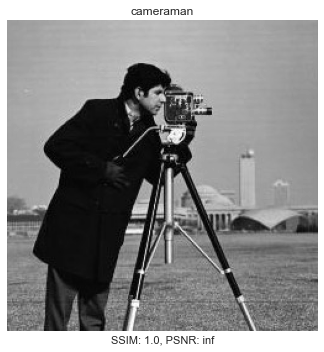

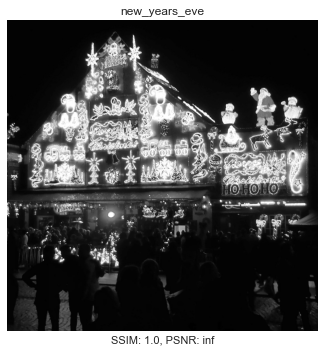

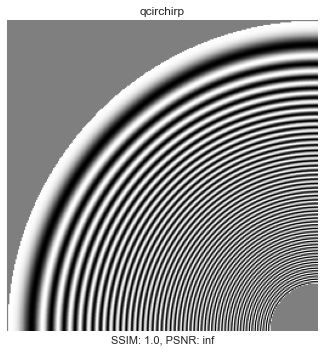

In [93]:
img = cv2.imread('images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)
exp1 = ExperimentHelper(img, title='cameraman')
_ = exp1.show(save_figure_name='cameraman')

img = cv2.imread('images/new_years_eve.jpg', cv2.IMREAD_GRAYSCALE)
exp2 = ExperimentHelper(img, title='new_years_eve')
_ = exp2.show(save_figure_name='new_years_eve')

img = cv2.imread('images/qcirchirp.bmp', cv2.IMREAD_GRAYSCALE)
exp3 = ExperimentHelper(img, title='qcirchirp')
_ = exp3.show(save_figure_name='qcirchirp')

In [ ]:
# can bilateral filtering tackle different noise types?
_ =exp3.add_noise(mode='s&p', amount=0.05)\
    .show(save_figure_name='qcirchirp_snp5')\
    .bilateral_filter(5, 50, 50)\
    .show(save_figure_name='qcirchirp_snp5_bilfil')\
    .reset()\
    .add_noise(mode='gaussian', var=0.02)\
    .show(save_figure_name='qcirchirp_gaussian002')\
    .bilateral_filter(5, 50, 50)\
    .show(save_figure_name='qcirchirp_gaussian5')\
    .reset()

In [ ]:
# How does bifi compare to gaussin filtering for different noise types?
_ =exp3.add_noise(mode='s&p', amount=0.1)\
    .show(save_figure_name='qcirchirp_snp10')\
    .bilateral_filter(7, 70, 70)\
    .show(save_figure_name='qcirchirp_snp10_bifi')\
    .reset()\
    .add_noise(mode='gaussian', var=0.1)\
    .show(save_figure_name='qcirchirp_gauss01')\
    .bilateral_filter(7, 70, 70)\
    .show(save_figure_name='qcirchirp_gauss01_bifi')\
    .reset()

_ =exp3.add_noise(mode='s&p', amount=0.1)\
    .show(save_figure_name='qcirchirp_snp10')\
    .gaussian_filter(7, 70, 70)\
    .show(save_figure_name='qcirchirp_snp10_gauss')\
    .reset()\
    .add_noise(mode='gaussian', var=0.1)\
    .show(save_figure_name='qcirchirp_gauss01')\
    .gaussian_filter(7, 70, 70)\
    .show(save_figure_name='qcirchirp_gauss01_gauss')\
    .reset()

In [ ]:
# How does parameters of bilat filtering affect the results?
for ss in [30, 80, 130]:
    for sc in [30, 80, 130]:
        _ =exp3.add_noise(mode='gaussian', var=0.1)\
            .bilateral_filter(7, sigmaSpace=ss, sigmaColor=sc)\
            .show(save_figure_name=f'qcirchirp_gauss01_bifi_ss{ss}_sc{sc}')\
            .reset()

for ss in [30, 80, 130]:
    for sc in [30, 80, 130]:
        _ =exp3.add_noise(mode='s&p', amount=0.1)\
            .bilateral_filter(7, sigmaSpace=ss, sigmaColor=sc)\
            .show(save_figure_name=f'qcirchirp_snp10_bifi_ss{ss}_sc{sc}')\
            .reset()

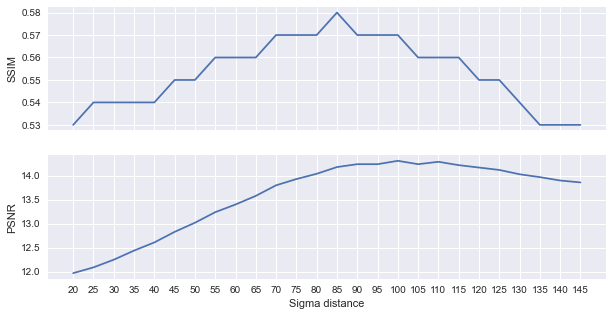

In [106]:
# How does each parameter affect the evaluation metrics when the other parameter is fixed?

ss = 80
ssim = []
psnr = []
steps = np.arange(20, 150, 5)

for sc in steps:
    metrics = exp3.reset().add_noise(mode='gaussian', var=0.1).\
        bilateral_filter(kernel=7, sigmaColor=sc, sigmaSpace=ss).get_metrics()
    ssim.append(metrics['ssim'])
    psnr.append(metrics['psnr'])

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,5))

ax0.set_ylabel('SSIM')
ax0.plot(steps, ssim)
ax1.set_ylabel('PSNR')
ax1.plot(steps, psnr)
plt.xlabel('Sigma distance')
plt.xticks(steps)
plt.savefig(f'figures/metrics_plot_fixed_ss_gauss', bbox_inches='tight')
plt.show()